# Ridge Regression (gradient descent) - R&I

We will:
* Computing the derivative of the regression weights by single features
* Find the gradient descent function to compute the regression weights by initial weight vector, step size, tolerance, and L2 penalty (regularization).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the house sales dataset

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int,
              'sqft_above':int, 'sqft_living15':float, 
              'grade':int, 'yr_renovated':int, 'price':float, 
              'bedrooms':float, 'zipcode':str, 'long':float, 
              'sqft_lot15':float, 'sqft_living':float, 'floors':str,
              'condition':int, 'lat':float, 'date':str, 
              'sqft_basement':int, 'yr_built':int, 'id':str, 
              'sqft_lot':int, 'view':int}

In [3]:
sales = pd.read_csv('kc_house_data.csv',dtype=dtype_dict)

In [4]:
sales.dtypes

id                object
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot           int32
floors            object
waterfront         int32
view               int32
condition          int32
grade              int32
sqft_above         int32
sqft_basement      int32
yr_built           int32
yr_renovated       int32
zipcode           object
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

# Plot House Prices from the Dataset

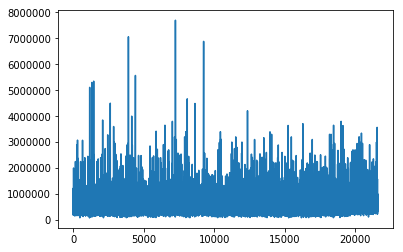

In [5]:
sales['price'].plot()



# Import functions 

In [6]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of 
    # the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given 
    # by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.as_matrix()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.as_matrix()
    return(feature_matrix, output_array)

The `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [7]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing 
    # the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix,weights)
    return(predictions)

# Compute the Derivative

The cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(wt)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(wt[0]^2 + wt[1]^2 + ... + wt[k]^2).
```

We now add the derivative of the regularization part the derivative of the RSS 
with respect to `wt[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `wt[i]` is:
```
2*l2_penalty*wt[i].
```
Adding both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*wt[i].
```
In other words, the derivative for the weight for 
feature i is the sum (over data points) of 
2 times the product of the error and the feature itself, plus `2*l2_penalty*wt[i]`. 

**We will not regularize the constant.**  
Thus, in the case of the constant, the derivative 
is just twice the sum of the errors (without the `2*l2_penalty*wt[0]` term).

In [8]:
def feature_derivative_ridge(errors, feature,weight, 
                             l2_penalty, feature_is_constant):
    # If feature_is_constant is True, 
    # derivative is twice the dot product of errors and feature
    if feature_is_constant:
        derivative = 2*np.dot(errors,feature)
    else:
        derivative = 2*np.dot(errors,feature) + 2*l2_penalty*weight
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    
    return derivative

Testing the feature derivartive:

In [9]:
(ML_features, ML_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
ML_weights = np.array([1., 10.])
test_predictions = predict_output(ML_features, ML_weights) 
errors = test_predictions - ML_output # prediction errors

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [10]:
# next two lines should print the same values
print feature_derivative_ridge(errors, ML_features[:,1],
                               ML_weights[1], 1, False)
print np.sum(errors*ML_features[:,1])*2+20.
print ''

-56554166815950.0
-56554166815950.0



In [11]:
# next two lines should print the same values
print feature_derivative_ridge(errors, ML_features[:,0], 
                               ML_weights[0], 1, True)
print np.sum(errors)*2.

-22446749330.0
-22446749330.0


# Gradient Descent

Gradient descent is used to minimize some function 
by iteratively moving in the direction of steepest descent 
as defined by the negative of the gradient. 
Gradient descent is to update the parameters of our model. 

The gradient is the direction of *increase* and 
therefore the negative gradient is the direction 
of *decrease* and we're trying to *minimize* a cost function. 

The move in the negative gradient *direction*  is called the 'step size'. 

Then when we are 'sufficiently close' to the optimum, 
we will set a **maximum number of iterations** and 
take gradient steps until we reach this maximum number. 
If no maximum number is supplied, the maximum should be set 100 by default. 

Thus we update the weight for each feature before computing our stopping criteria.

In [12]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 
                                      l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) 
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix 
        # and weights using your predict_output() function
        predictions = predict_output(feature_matrix,weights)
        # compute the errors as predictions - output
        errors = predictions - output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print 'Cost function = ', str(np.dot(errors,errors) + 
                                          l2_penalty*(np.dot(weights,weights) 
                                                      - weights[0]**2))
        
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column 
            # associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0 :
                derivative = feature_derivative_ridge(errors, 
                                                      feature_matrix[:,i], 
                                                      weights[i], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, 
                                                      feature_matrix[:,i], 
                                                      weights[i], l2_penalty, False)

            # subtract the step size times the derivative from the current weight
            weights[i] -=  (step_size*derivative)
    print 'gradient descent iteration completed', iteration
    print 'Learned weights = ', str(weights)
    return weights

# Studying the L2 penalty

We now study how the large weights get penalized and consider ML1 with 1 feature:

In [13]:
ML1_features = ['sqft_living']
ML1_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [14]:
train_data = pd.read_csv('kc_house_train_data.csv',dtype = dtype_dict)
test_data = pd.read_csv('kc_house_test_data.csv',dtype=dtype_dict)

In this part, we will use only `'sqft_living'` to 
predict `'price'`for both the `train_data` and the `test_data`. 

In [15]:
(ML1_feature_matrix, output) = get_numpy_data(train_data, 
                                              ML1_features, ML1_output)
(ML1_test_feature_matrix, test_output) = get_numpy_data(test_data, 
                                                        ML1_features, ML1_output)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Now let us view the parameters for our optimization:

In [16]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization where the `l2_penalty` to `0.0`

In [17]:
ML1_weights_0_penalty=ridge_regression_gradient_descent(ML1_feature_matrix, 
                                                        output, initial_weights, 
                                                        step_size, 0.0, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5394267213533688.0
Iteration = 3
Cost function =  4023237736286403.0
Iteration = 4
Cost function =  3101256183295487.0
Iteration = 5
Cost function =  2481247643601011.5
Iteration = 6
Cost function =  2064308076801447.0
Iteration = 7
Cost function =  1783927096156441.0
Iteration = 8
Cost function =  1595378201854742.0
Iteration = 9
Cost function =  1468583989698184.5
Iteration = 10
Cost function =  1383318190090050.5
Iteration = 20
Cost function =  1211562139024524.2
Iteration = 30
Cost function =  1208313761205656.5
Iteration = 40
Cost function =  1208252324779675.5
Iteration = 50
Cost function =  1208251162139724.5
Iteration = 60
Cost function =  1208251139442068.0
Iteration = 70
Cost function =  1208251138303841.0
Iteration = 80
Cost function =  1208251137573361.5
Iteration = 90
Cost function =  1208251136850593.8
Iteration = 100
Cost function =  1208251136

Now we consider high regularization with the `l2_penalty` to `1e11` 

In [18]:
ML1_weights_high_penalty=ridge_regression_gradient_descent(ML1_feature_matrix, 
                                                           output, initial_weights, 
                                                           step_size, 1e11, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5618303898910948.0
Iteration = 3
Cost function =  4920613278301801.0
Iteration = 4
Cost function =  4652381942678798.0
Iteration = 5
Cost function =  4549258764034560.0
Iteration = 6
Cost function =  4509612390884944.0
Iteration = 7
Cost function =  4494370050276983.0
Iteration = 8
Cost function =  4488509984023467.0
Iteration = 9
Cost function =  4486256988524009.0
Iteration = 10
Cost function =  4485390752666539.0
Iteration = 20
Cost function =  4484848868025912.0
Iteration = 30
Cost function =  4484847880470641.0
Iteration = 40
Cost function =  4484846931073274.5
Iteration = 50
Cost function =  4484845981678999.0
Iteration = 60
Cost function =  4484845032285121.5
Iteration = 70
Cost function =  4484844082891643.5
Iteration = 80
Cost function =  4484843133498564.0
Iteration = 90
Cost function =  4484842184105884.0
Iteration = 100
Cost function =  44848412

We now plot the two learned models with the following:

* Blue - no regularization 
* Red - high regularization

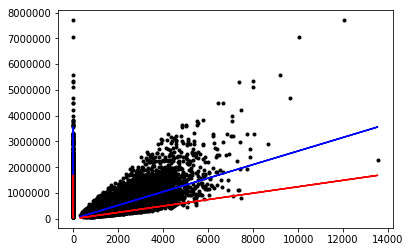

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ML1_feature_matrix,output,'k.',
         ML1_feature_matrix,predict_output(ML1_feature_matrix, 
                                           ML1_weights_0_penalty),'b-',
        ML1_feature_matrix,predict_output(ML1_feature_matrix, 
                                          ML1_weights_high_penalty),'r-')

We now compare weights learned with no regularization and high regularization using the RSS on the TEST data. 

In [20]:
ML_RSS1 = sum((-test_output)**2)
ML_RSS2 = ((predict_output(ML1_test_feature_matrix,
                           ML1_weights_0_penalty)-test_output)**2).sum()
ML_RSS3 = sum((predict_output(ML1_test_feature_matrix,
                              ML1_weights_high_penalty)-test_output)**2)
print "RSS1: " + str(ML_RSS1)
print "RSS2: " + str(ML_RSS2)
print "RSS3: " + str(ML_RSS3)

RSS1: 1784273286136298.0
RSS2: 275723632153607.44
RSS3: 694642101489902.6


In [21]:
print "No Regulaization with value 1: " + str(ML1_weights_0_penalty[1])
print "High Regularization value 1: " + str(ML1_weights_high_penalty[1])

No Regulaization with value 1: 263.0243689653849
High Regularization value 1: 124.57217567413909


# Multiple regression with L2 penalty

In [22]:
sales.dtypes

id                object
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot           int32
floors            object
waterfront         int32
view               int32
condition          int32
grade              int32
sqft_above         int32
sqft_basement      int32
yr_built           int32
yr_renovated       int32
zipcode           object
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
constant           int64
dtype: object

Now we will study a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, we using the training and test data with these two features. 

In [23]:
ML2_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the 
                                                # average squarefeet 
                                                # for the nearest 15 neighbors. 
ML2_output = 'price'
(ML2_feature_matrix, output) = get_numpy_data(train_data, 
                                              ML2_features, 
                                              ML2_output)
(ML2_test_feature_matrix, test_output) = get_numpy_data(test_data, 
                                                        ML2_features, 
                                                        ML2_output)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


We need to re-inialize the weights, set the step size 
to `1e-12` and maximum number of iterations `1000` .

In [24]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization where the `l2_penalty` to `0.0`

In [25]:
ML2_weights_0_penalty = ridge_regression_gradient_descent(ML2_feature_matrix, 
                                                          output, initial_weights, 
                                                          step_size, 0.0, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4056752332045942.5
Iteration = 3
Cost function =  2529565114525309.5
Iteration = 4
Cost function =  1838556694300507.0
Iteration = 5
Cost function =  1525675575150296.8
Iteration = 6
Cost function =  1383789498571784.0
Iteration = 7
Cost function =  1319232606146273.5
Iteration = 8
Cost function =  1289648871879140.8
Iteration = 9
Cost function =  1275884723913737.0
Iteration = 10
Cost function =  1269278807397619.2
Iteration = 20
Cost function =  1257812386017016.2
Iteration = 30
Cost function =  1251954570861556.0
Iteration = 40
Cost function =  1246755422656426.0
Iteration = 50
Cost function =  1242139508166548.5
Iteration = 60
Cost function =  1238041400480994.0
Iteration = 70
Cost function =  1234403012742170.5
Iteration = 80
Cost function =  1231172774196731.0
Iteration = 90
Cost function =  1228304899227735.2
Iteration = 100
Cost function =  1225758738

Now we consider high regularization with the `l2_penalty` to `1e11` 

In [26]:
ML2_weights_high_penalty = ridge_regression_gradient_descent(ML2_feature_matrix, 
                                                             output, initial_weights, 
                                                             step_size, 1e11, max_iterations)

Starting gradient descent with l2_penalty = 1e+11
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4460489790922030.5
Iteration = 3
Cost function =  3796674469325300.0
Iteration = 4
Cost function =  3648319530880128.0
Iteration = 5
Cost function =  3615091103648369.0
Iteration = 6
Cost function =  3607602742943372.0
Iteration = 7
Cost function =  3605886322588678.0
Iteration = 8
Cost function =  3605474874959446.0
Iteration = 9
Cost function =  3605365168191211.5
Iteration = 10
Cost function =  3605329402609966.0
Iteration = 20
Cost function =  3605294281447482.0
Iteration = 30
Cost function =  3605293537691883.0
Iteration = 40
Cost function =  3605293083174690.0
Iteration = 50
Cost function =  3605292631531144.0
Iteration = 60
Cost function =  3605292179916289.0
Iteration = 70
Cost function =  3605291728301859.0
Iteration = 80
Cost function =  3605291276687576.0
Iteration = 90
Cost function =  3605290825073435.0
Iteration = 100
Cost function =  36052903

We now plot the two learned models with the following:

* Blue - no regularization 
* Red - high regularization

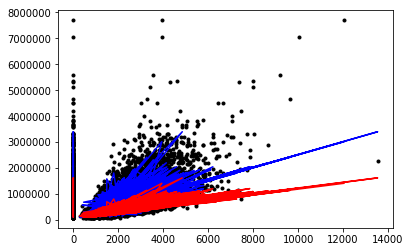

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ML2_feature_matrix,output,'k.',
         ML2_feature_matrix,predict_output(ML2_feature_matrix, 
                                           ML2_weights_0_penalty),'b-',
        ML2_feature_matrix,predict_output(ML2_feature_matrix, 
                                          ML2_weights_high_penalty),'r-')

We now compare weights learned with no regularization and high regularization using the RSS on the TEST data. 

In [28]:
ML_RSS1 = sum((-test_output)**2)
ML_RSS2 = ((predict_output(ML2_test_feature_matrix,
                           ML2_weights_0_penalty)-test_output)**2).sum()
ML_RSS3 = sum((predict_output(ML2_test_feature_matrix,
                              ML2_weights_high_penalty)-test_output)**2)
print "RSS1: " + str(ML_RSS1)
print "RSS2: " + str(ML_RSS2)
print "RSS3: " + str(ML_RSS3)

RSS1: 1784273286136298.0
RSS2: 274067615918575.53
RSS3: 500404800500840.75


We now predict the house price for the 1st house in the test set using the no regularization and high regularization models. 

In [29]:
print "Predicted 1st house (No Regularization): " + str(predict_output(ML2_test_feature_matrix,
                                                                                     ML2_weights_0_penalty)[0])
print "Predicted 1st house (High Regularization): " + str(predict_output(ML2_test_feature_matrix,
                                                                                       ML2_weights_high_penalty)[0])
print "Actual house price: " + str(test_output[0])

Predicted 1st house (No Regularization): 387465.47605823533
Predicted 1st house (High Regularization): 270453.53032194055
Actual house price: 310000.0


We now predict the house price for the 11th house in the test set using the no regularization and high regularization models. 

In [30]:
print "Predicted 11th house (No Regularization): " + str(predict_output(ML2_test_feature_matrix,
                                                                        ML2_weights_0_penalty)[10])
print "Predicted 11th house (High Regularization): " + str(predict_output(ML2_test_feature_matrix,
                                                                          ML2_weights_high_penalty)[10])
print "Actual house price: " + str(test_output[10])

Predicted 11th house (No Regularization): 478551.3475892041
Predicted 11th house (High Regularization): 315939.5228610413
Actual house price: 349000.0
